In [1]:
# Cell 1: Imports & Config
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from alpaca.trading.client import TradingClient
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

import config

# Alpaca clients
trading_client = TradingClient(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY, paper=True)
data_client = StockHistoricalDataClient(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY)

In [2]:
# Cell 2: Utility functions
def get_candles(symbol, timeframe, start, end, limit=None):
    """
    Fetch historical OHLCV bars from Alpaca.
    """
    request_params = StockBarsRequest(
        symbol_or_symbols=[symbol],
        timeframe=timeframe,
        start=start,
        end=end,
        limit=limit
    )
    bars = data_client.get_stock_bars(request_params)
    df = bars.df.reset_index()
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']].copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def compute_atr(df, period=14):
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift(1)).abs()
    low_close = (df['low'] - df['close'].shift(1)).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr


In [3]:
# Cell 3: Stop-loss & Take-profit Managers
class StopLossManager:
    def __init__(self, entry_price, direction="long", method="atr", atr=None, multiplier=2):
        self.entry_price = entry_price
        self.direction = direction
        self.method = method
        self.atr = atr
        self.multiplier = multiplier
        if direction == "long":
            self.stop_price = entry_price - multiplier * atr
        else:
            self.stop_price = entry_price + multiplier * atr

    def update(self, current_price, atr=None):
        if self.method == "atr" and atr is not None:
            if self.direction == "long":
                self.stop_price = max(self.stop_price, current_price - self.multiplier * atr)
            else:
                self.stop_price = min(self.stop_price, current_price + self.multiplier * atr)
        return self.stop_price

class TakeProfitManager:
    def __init__(self, entry_price, direction="long", rr_ratio=2, atr=None, multiplier=2):
        self.entry_price = entry_price
        self.direction = direction
        self.rr_ratio = rr_ratio
        self.atr = atr
        self.multiplier = multiplier
        if direction == "long":
            self.tp_price = entry_price + rr_ratio * multiplier * atr
        else:
            self.tp_price = entry_price - rr_ratio * multiplier * atr

    def update(self, current_price, atr=None):
        if atr is not None:
            if self.direction == "long":
                self.tp_price = max(self.tp_price, current_price + self.multiplier * atr)
            else:
                self.tp_price = min(self.tp_price, current_price - self.multiplier * atr)
        return self.tp_price


In [4]:
# Cell 4: Position Sizing
def calculate_position_size(api, symbol, entry_price, stop_price, risk_percent=0.01):
    """
    Calculate position size based on account equity and stop-loss.
    """
    account = api.get_account()
    equity = float(account.equity)
    risk_capital = equity * risk_percent
    risk_per_share = abs(entry_price - stop_price)
    if risk_per_share == 0:
        raise ValueError("Stop price cannot equal entry price")
    position_size = risk_capital / risk_per_share
    return int(position_size)


In [5]:
# Cell 5: SMA Crossover Signals
def generate_signals(df, fast=5, slow=20):
    """
    Generates 1 (buy) / -1 (sell) / 0 (hold) signals based on SMA crossover.
    """
    df['SMA_Fast'] = df['close'].rolling(fast).mean()
    df['SMA_Slow'] = df['close'].rolling(slow).mean()
    df['Signal'] = 0
    df.loc[df['SMA_Fast'] > df['SMA_Slow'], 'Signal'] = 1
    df.loc[df['SMA_Fast'] < df['SMA_Slow'], 'Signal'] = -1
    return df


In [6]:
# Cell 6: Trade Manager
class TradeManager:
    def __init__(self, api, capital=10000, risk_per_trade=0.01, live=False):
        self.api = api
        self.capital = capital
        self.risk_per_trade = risk_per_trade
        self.live = live
        self.open_trades = []
        self.closed_trades = []

    def open_trade(self, symbol, direction, entry_price, stop_price, tp_price):
        size = calculate_position_size(self.api, symbol, entry_price, stop_price, self.risk_per_trade)
        trade = {
            'symbol': symbol,
            'direction': direction,
            'entry': entry_price,
            'stop': stop_price,
            'tp': tp_price,
            'size': size,
            'opened_at': datetime.now()
        }
        if self.live:
            order = MarketOrderRequest(
                symbol=symbol,
                qty=size,
                side=OrderSide.BUY if direction=='long' else OrderSide.SELL,
                time_in_force=TimeInForce.DAY
            )
            self.api.submit_order(order)
        self.open_trades.append(trade)

    def close_trade(self, trade, exit_price):
        trade['exit'] = exit_price
        trade['closed_at'] = datetime.now()
        self.closed_trades.append(trade)
        self.open_trades.remove(trade)

    def check_trades(self, current_price):
        for trade in self.open_trades.copy():
            if trade['direction']=='long':
                if current_price <= trade['stop'] or current_price >= trade['tp']:
                    self.close_trade(trade, current_price)
            else:
                if current_price >= trade['stop'] or current_price <= trade['tp']:
                    self.close_trade(trade, current_price)


In [7]:
# Cell 7: Backtest Runner
def run_backtest(symbol, df, TM, atr_period=14, rr=2):
    df['atr'] = compute_atr(df, atr_period)
    df = generate_signals(df)
    for i, row in df.iterrows():
        if row['Signal'] == 1:  # Buy
            sl = StopLossManager(row['close'], 'long', atr=row['atr']).stop_price
            tp = TakeProfitManager(row['close'], 'long', rr_ratio=rr, atr=row['atr']).tp_price
            TM.open_trade(symbol, 'long', row['close'], sl, tp)
        elif row['Signal'] == -1:  # Sell
            sl = StopLossManager(row['close'], 'short', atr=row['atr']).stop_price
            tp = TakeProfitManager(row['close'], 'short', rr_ratio=rr, atr=row['atr']).tp_price
            TM.open_trade(symbol, 'short', row['close'], sl, tp)
        TM.check_trades(row['close'])
    return TM.closed_trades


In [8]:
# Cell 8: Visualization
def plot_trades(df, closed_trades, title="SMA Crossover Trades"):
    plt.figure(figsize=(14,6))
    plt.plot(df['timestamp'], df['close'], label='Close', color='blue')
    for trade in closed_trades:
        plt.scatter(trade['opened_at'], trade['entry'], marker='^' if trade['direction']=='long' else 'v', color='green' if trade['direction']=='long' else 'red')
        plt.scatter(trade['closed_at'], trade['exit'], marker='x', color='black')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()


In [10]:
def evaluate_performance(closed_trades):
    df = pd.DataFrame(closed_trades)
    if df.empty:
        print("No trades executed.")
        return None

    df['PnL'] = (df['exit'] - df['entry']) * df['size'] * df['direction'].apply(lambda x: 1 if x=='long' else -1)
    total_return = df['PnL'].sum()
    win_rate = (df['PnL'] > 0).mean() * 100
    avg_trade = df['PnL'].mean()
    max_drawdown = (df['PnL'].cumsum().cummax() - df['PnL'].cumsum()).max()

    print(f"📊 Backtest Results")
    print(f"Total Trades: {len(df)}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total Return: ${total_return:.2f}")
    print(f"Average Trade PnL: ${avg_trade:.2f}")
    print(f"Max Drawdown: ${max_drawdown:.2f}")

    return df


In [13]:
def plot_equity_curve(trades_df):
    """
    Plot cumulative PnL (Equity Curve) from closed trades.
    """
    trades_df = trades_df.copy()
    trades_df['equity'] = trades_df['PnL'].cumsum()

    plt.figure(figsize=(12,5))
    plt.plot(trades_df['closed_at'], trades_df['equity'], label='Equity Curve', color='purple')
    plt.title("Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.legend()
    plt.show()


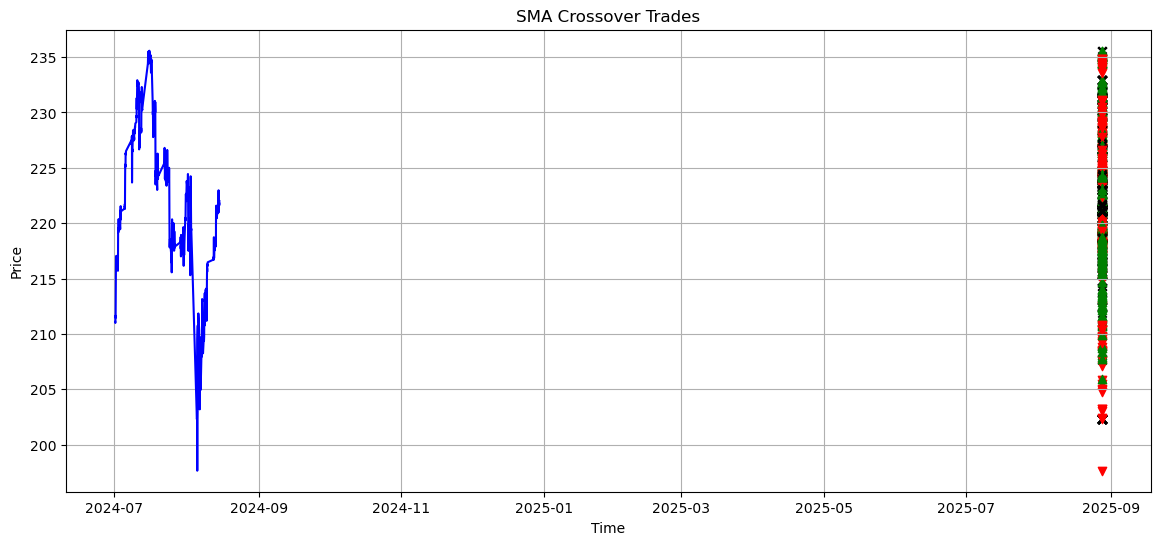

📊 Backtest Results
Total Trades: 460
Win Rate: 45.43%
Total Return: $113656.96
Average Trade PnL: $247.08
Max Drawdown: $129291.83


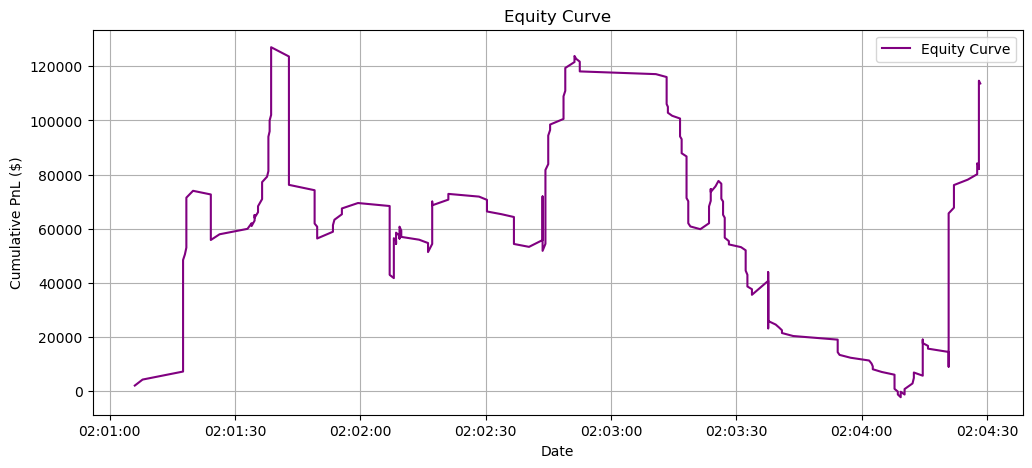

,symbol,direction,entry,stop,tp,size,opened_at,exit,closed_at
0,AAPL,long,215.7000,213.854843,219.390314,541,2025-08-28 02:01:05.131781,219.5398,2025-08-28 02:01:06.026271
1,AAPL,long,215.7000,213.593414,219.913171,474,2025-08-28 02:01:04.799042,220.3700,2025-08-28 02:01:07.891233
2,AAPL,long,217.9850,215.922700,222.109600,484,2025-08-28 02:01:05.486520,224.1052,2025-08-28 02:01:17.578486
3,AAPL,long,219.5398,217.474643,223.670114,484,2025-08-28 02:01:06.026271,224.1052,2025-08-28 02:01:17.578486
4,AAPL,long,219.2700,217.181986,223.446029,478,2025-08-28 02:01:06.390447,224.1052,2025-08-28 02:01:17.578486
...,...,...,...,...,...,...,...,...,...
455,AAPL,long,218.6600,216.584671,222.810657,481,2025-08-28 02:04:19.148270,222.9701,2025-08-28 02:04:28.028517
456,AAPL,long,217.8900,215.777529,222.114943,473,2025-08-28 02:04:19.660333,222.9701,2025-08-28 02:04:28.028517
457,AAPL,long,218.2400,216.353243,222.013514,530,2025-08-28 02:04:19.980896,222.9701,2025-08-28 02:04:28.028517
458,AAPL,long,218.5009,216.755571,221.991557,572,2025-08-28 02:04:20.386375,222.9701,2025-08-28 02:04:28.028517


In [14]:
# Cell 9: Run Example Backtest & Show Results
symbol = "AAPL"
start = datetime(2024, 7, 1)
end = datetime(2024, 8, 15)

# Get data
df = get_candles(symbol, TimeFrame.Hour, start, end)

# Initialize Trade Manager
TM = TradeManager(trading_client, capital=10000, risk_per_trade=0.01, live=False)

# Run backtest
closed_trades = run_backtest(symbol, df, TM)

# Plot trades
plot_trades(df, closed_trades)

# Evaluate performance
results_df = evaluate_performance(closed_trades)

# Plot equity curve if trades exist
if results_df is not None:
    plot_equity_curve(results_df)

# Display closed trades DataFrame
pd.DataFrame(closed_trades)
